In [8]:
from entsoe import EntsoePandasClient, mappings
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import itertools
import os
from tqdm import tqdm
import geopandas as gpd
from aquarel import load_theme
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pyproj

In [9]:
load_dotenv()  # load env file
entsoe_key = os.getenv("ENTSOE_API_KEY")  # Get API keys from .env file

# Instantiate the ENTSOE Client
client = EntsoePandasClient(api_key=entsoe_key)

# Data Query

In [10]:
start_date = pd.Timestamp(year=2024, month=8, day=1, tz="utc")
end_date = pd.Timestamp(year=2024, month=8, day=2, tz="utc")

# Define the countries, CORE CCR countries are: AT BE HR CZ FR DE HU LU NL PL RO SK SI   
countries = ["AT", "BE", "CZ", "FR", "DE_LU", "HU","NL", "PL", "RO", "SK", "SI", "PL", "CH"]

# Define the neighbors of the countries
neighbors = mappings.NEIGHBOURS

In [11]:
# Query the data and save it to a csv file
country_pairs = (
    pd.DataFrame(itertools.product(countries, countries))
    .rename(columns={0: "flow_from", 1: "flow_to"})
    .drop_duplicates()
    .query("flow_from != flow_to")
    .reset_index(drop=True)
)

In [12]:
# Create a list of valid pairs
valid_pairs = []
for country, neighbors_list in neighbors.items():
    for neighbor in neighbors_list:
        if country in countries and neighbor in countries:
            valid_pairs.append((country, neighbor))
            valid_pairs.append((neighbor, country))  # Include both directions

# Convert the list of valid pairs into a DataFrame
valid_pairs_df = pd.DataFrame(valid_pairs, columns=["flow_from", "flow_to"])

# Merge with the original country_pairs to filter only valid pairs
filtered_country_pairs = pd.merge(country_pairs, valid_pairs_df, on=["flow_from", "flow_to"]).drop_duplicates()

# filtered_country_pairs now contains only the valid flows based on neighbors

In [13]:
# Initialize an empty list to store individual dictionaries
all_flows = []

# Loop through each index in filtered_country_pairs
for idx in tqdm(filtered_country_pairs.index):
    data = client.query_crossborder_flows(
        country_code_from=filtered_country_pairs.loc[idx, "flow_from"],
        country_code_to=filtered_country_pairs.loc[idx, "flow_to"],
        start=start_date,
        end=end_date,
    )
    # Extract the maximum value from the returned series
    max_value = data.max() if not data.empty else None
    # Store the result in a dictionary
    flow_dict = {
        "flow_from": filtered_country_pairs.loc[idx, "flow_from"],
        "flow_to": filtered_country_pairs.loc[idx, "flow_to"],
        "max_value": max_value
    }
    # Append the dictionary to the list
    all_flows.append(flow_dict)

# Convert the list of dictionaries into a single dataframe
flow_df = pd.DataFrame(all_flows)

100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


In [14]:
# save to parquet
flow_df.to_parquet("maps/flow_data.parquet")

# Flow Visualization

In [15]:
# Set up the plot theme
theme = (
    load_theme("boxy_light")
    .set_overrides({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern']
    })
)
theme.apply()

In [16]:
countrynames = ["France", "Germany", "Austria", "Switzerland", "Belgium", "Netherlands", "Poland", "Czechia", "Slovakia", "Hungary", "Croatia", "Slovenia", "Luxembourg", "Romania"]
# Filter the GeoDataFrame
world = gpd.read_file('maps/ne_10m_admin_0_countries.shp')
europe_subset = world[world['ADMIN'].isin(countrynames)]

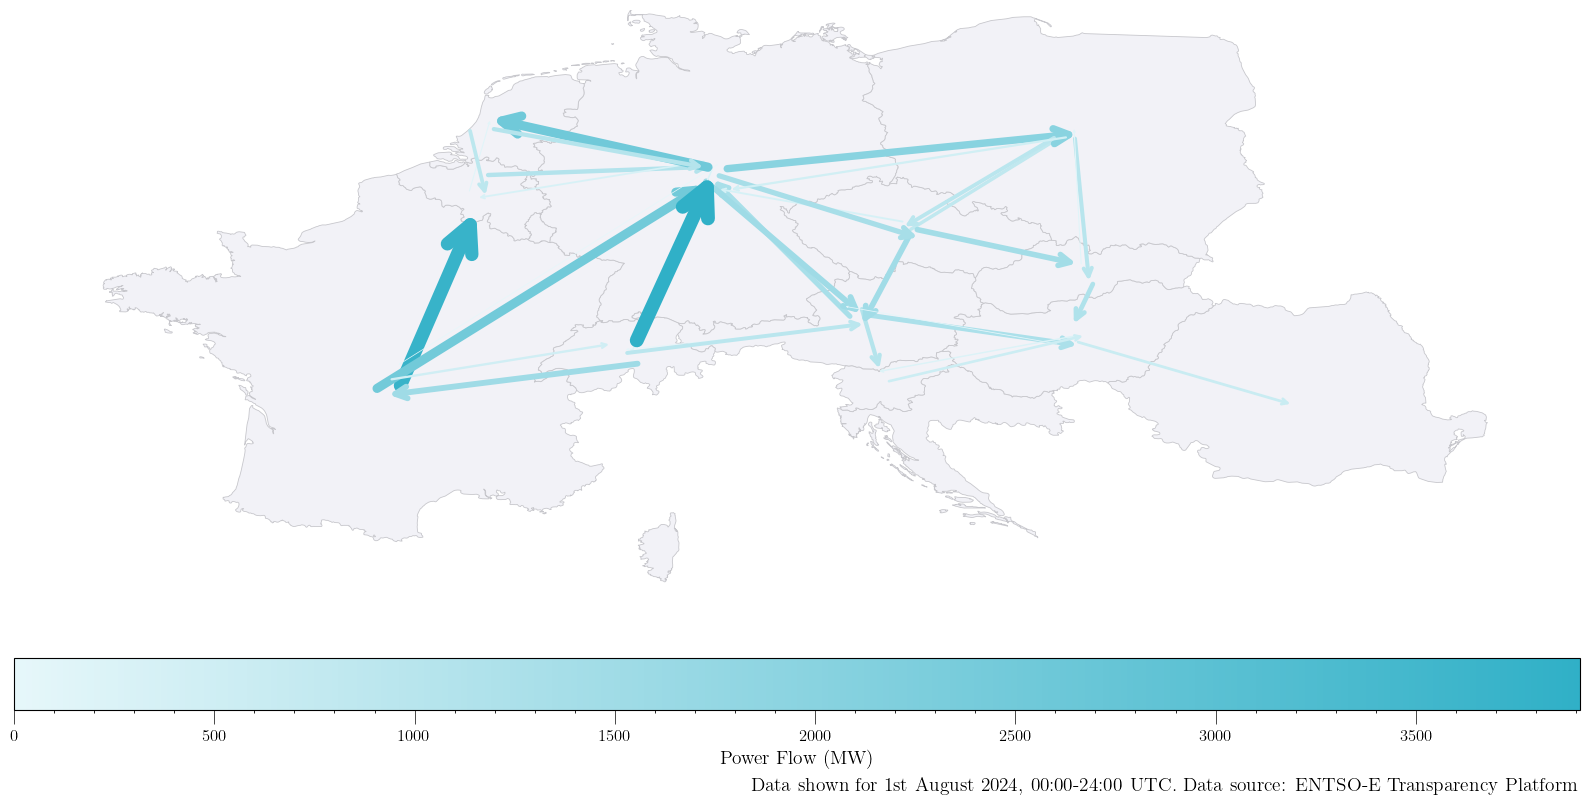

In [38]:
# Define a suitable projection for Europe (EPSG:3035 - ETRS89-extended / LAEA Europe)
europe_crs = 'EPSG:3035'

# Create a projected version for centroid calculations
europe_subset_projected = europe_subset.to_crs(europe_crs)

# Create transformer for converting coordinates
transformer = pyproj.Transformer.from_crs(europe_subset.crs, europe_crs, always_xy=True)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the map
europe_subset.plot(ax=ax, color='#f2f2f7', edgecolor='#c7c7cc', linewidth=0.6)

# Set limits to focus the map view
ax.set_xlim(-5, 30)  # Longitude range for Europe
ax.set_ylim(41, 55)   # Latitude range for Europe

# Function to get country centroid
def get_country_centroid(country_name):
    if country_name == 'France':
        # Manually set centroid for France
        return (2.2137, 46.2276)
    country = europe_subset_projected[europe_subset_projected['ADMIN'] == country_name]
    if not country.empty:
        centroid = country.geometry.centroid.iloc[0]
        # Convert centroid back to original CRS
        return transformer.transform(centroid.x, centroid.y, direction='INVERSE')
    return None

# Dictionary to map country codes to names
country_code_to_name = {
    'FR': 'France', 'DE_LU': 'Germany', 'AT': 'Austria', 'CH': 'Switzerland',
    'BE': 'Belgium', 'NL': 'Netherlands', 'PL': 'Poland', 'CZ': 'Czechia',
    'SK': 'Slovakia', 'HU': 'Hungary', 'HR': 'Croatia', 'SI': 'Slovenia', 'RO': 'Romania'
}

# Function to add jitter to coordinates
def add_jitter(coord, scale=0.2):
    return coord[0] + np.random.normal(0, scale), coord[1] + np.random.normal(0, scale)

# Create a custom colormap
# cmap = plt.colormaps['Blues']
# Define the color #30b0c7
base_color = '#30b0c7'

# Create a custom colormap
light_color = '#e6f7fa'  # A very light version of #30b0c7
cmap = LinearSegmentedColormap.from_list("custom_blue", [light_color, base_color])



# Function to calculate arrow properties based on flow value
def get_arrow_properties(value):
    max_width = 10  # Maximum arrow width
    min_width = 0.5  # Minimum arrow width
    max_value = flow_df['max_value'].max()
    width = np.interp(value, [0, max_value], [min_width, max_width])
    color = cmap(value / max_value)
    return width, color

# Draw arrows for flows
for _, flow in flow_df.iterrows():
    if flow['max_value'] > 0:
        start = get_country_centroid(country_code_to_name[flow['flow_from']])
        end = get_country_centroid(country_code_to_name[flow['flow_to']])
        if start and end:
            # Add jitter to start and end points
            start_jittered = add_jitter(start)
            end_jittered = add_jitter(end)
            
            width, color = get_arrow_properties(flow['max_value'])
            ax.annotate('', xy=end_jittered, xytext=start_jittered,
                        arrowprops=dict(arrowstyle='->', color=color, 
                                        linewidth=width,
                                        mutation_scale=5*width),  # Adjust arrow head size
                        )

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=flow_df['max_value'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Power Flow (MW)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Remove axes
ax.axis('off')

# Add note below the plot
note_text = "Data shown for 1st August 2024, 00:00-24:00 UTC. Data source: ENTSO-E Transparency Platform"
plt.figtext(0.99, 0, note_text, wrap=True, horizontalalignment='right', fontsize=14, va='bottom')

# Adjust layout to make room for the note
plt.tight_layout()
# plt.subplots_adjust(bottom=0.1)  # Adjust bottom margin to make space for the note

# Show the plot
plt.show()

In [39]:
import getpass
export_username = "ts" # Only save plots to dropbox on my machine
def save_plot(plot, filename):
    username = getpass.getuser()
    filepath = "/Users/ts/Library/CloudStorage/Dropbox/Apps/Overleaf/Dissertation Oxford/Figures"
    filename += ".pdf"
    if username == export_username:
        plot.savefig(os.path.join(filepath, filename), format='pdf') 

In [40]:
save_plot(fig, "Crossborder_Flows")

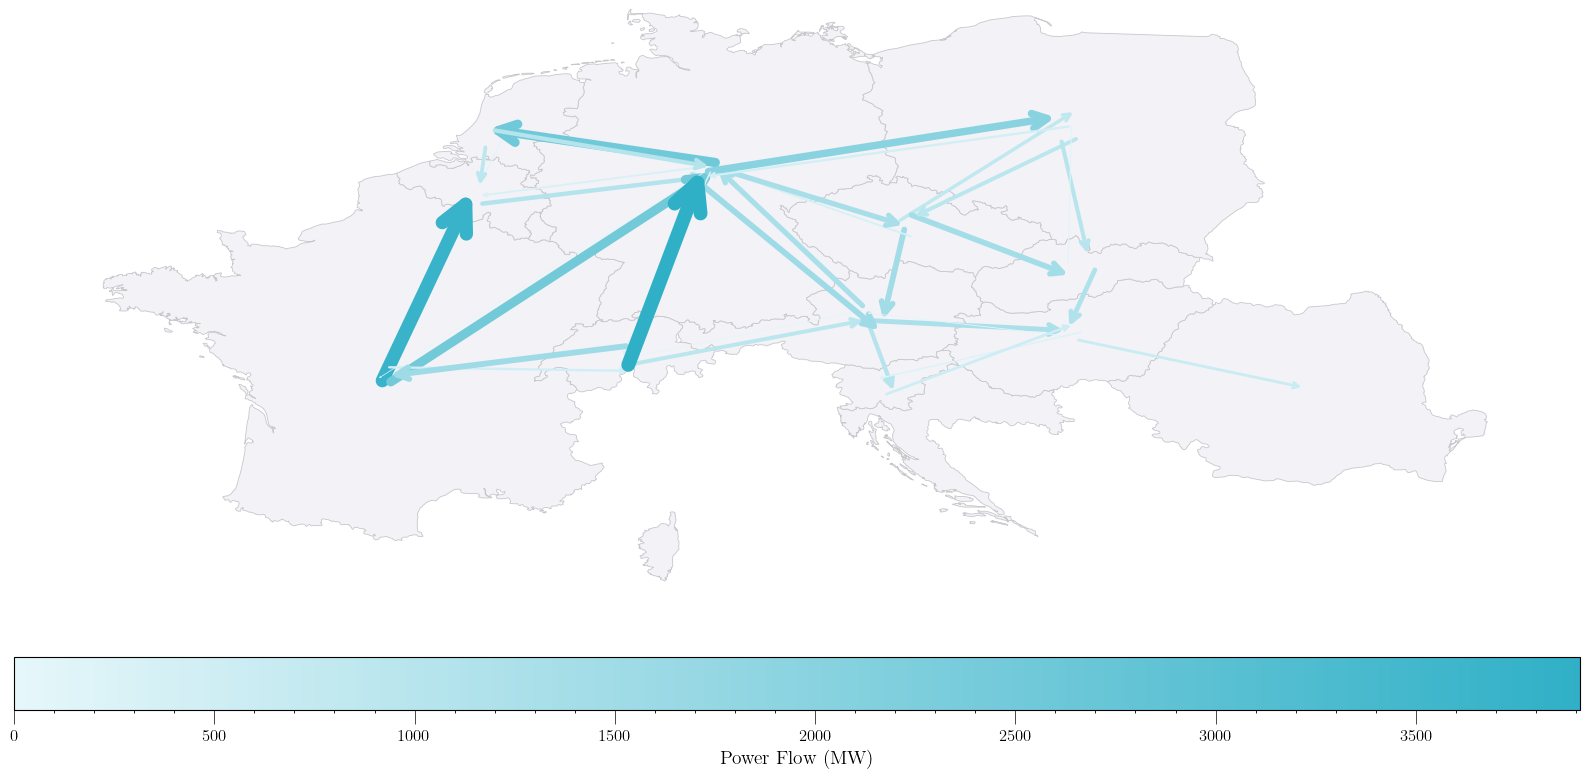

In [41]:
# Define a suitable projection for Europe (EPSG:3035 - ETRS89-extended / LAEA Europe)
europe_crs = 'EPSG:3035'

# Create a projected version for centroid calculations
europe_subset_projected = europe_subset.to_crs(europe_crs)

# Create transformer for converting coordinates
transformer = pyproj.Transformer.from_crs(europe_subset.crs, europe_crs, always_xy=True)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the map
europe_subset.plot(ax=ax, color='#f2f2f7', edgecolor='#c7c7cc', linewidth=0.6)

# Set limits to focus the map view
ax.set_xlim(-5, 30)  # Longitude range for Europe
ax.set_ylim(41, 55)   # Latitude range for Europe

# Function to get country centroid
def get_country_centroid(country_name):
    if country_name == 'France':
        # Manually set centroid for France
        return (2.2137, 46.2276)
    country = europe_subset_projected[europe_subset_projected['ADMIN'] == country_name]
    if not country.empty:
        centroid = country.geometry.centroid.iloc[0]
        # Convert centroid back to original CRS
        return transformer.transform(centroid.x, centroid.y, direction='INVERSE')
    return None

# Dictionary to map country codes to names
country_code_to_name = {
    'FR': 'France', 'DE_LU': 'Germany', 'AT': 'Austria', 'CH': 'Switzerland',
    'BE': 'Belgium', 'NL': 'Netherlands', 'PL': 'Poland', 'CZ': 'Czechia',
    'SK': 'Slovakia', 'HU': 'Hungary', 'HR': 'Croatia', 'SI': 'Slovenia', 'RO': 'Romania'
}

# Function to add jitter to coordinates
def add_jitter(coord, scale=0.2):
    return coord[0] + np.random.normal(0, scale), coord[1] + np.random.normal(0, scale)

# Create a custom colormap
# cmap = plt.colormaps['Blues']
# Define the color #30b0c7
base_color = '#30b0c7'

# Create a custom colormap
light_color = '#e6f7fa'  # A very light version of #30b0c7
cmap = LinearSegmentedColormap.from_list("custom_blue", [light_color, base_color])



# Function to calculate arrow properties based on flow value
def get_arrow_properties(value):
    max_width = 10  # Maximum arrow width
    min_width = 0.5  # Minimum arrow width
    max_value = flow_df['max_value'].max()
    width = np.interp(value, [0, max_value], [min_width, max_width])
    color = cmap(value / max_value)
    return width, color

# Draw arrows for flows
for _, flow in flow_df.iterrows():
    if flow['max_value'] > 0:
        start = get_country_centroid(country_code_to_name[flow['flow_from']])
        end = get_country_centroid(country_code_to_name[flow['flow_to']])
        if start and end:
            # Add jitter to start and end points
            start_jittered = add_jitter(start)
            end_jittered = add_jitter(end)
            
            width, color = get_arrow_properties(flow['max_value'])
            ax.annotate('', xy=end_jittered, xytext=start_jittered,
                        arrowprops=dict(arrowstyle='->', color=color, 
                                        linewidth=width,
                                        mutation_scale=5*width),  # Adjust arrow head size
                        )

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=flow_df['max_value'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Power Flow (MW)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Remove axes
ax.axis('off')

# Adjust layout to make room for the note
plt.tight_layout()

# Show the plot
plt.show()

In [42]:
plt.savefig("flows.png")

<Figure size 640x480 with 0 Axes>